In [20]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd/fangming/CEMBA/scripts/ClusterCrossValidation')
import importlib


from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
from sklearn.model_selection import KFold
import pickle

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import cluster_cv_utils
importlib.reload(cluster_cv_utils)
from cluster_cv_utils import *


In [21]:
analysis_name = 'summary_scf_8mods_cv_190724'
name_format = 'mop_cv_scf_8mods_n{}_190724'
output_figure_dir = '/cndd/fangming/CEMBA/data/MOp_all/results/figures'

# Configs  

In [22]:
log = snmcseq_utils.create_logger()
logging.info('*')

07/29/2019 10:21:13 AM *


In [23]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/organized_neurons_v8'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [24]:
# ps = np.linspace(0.1, 1, 10)[::-1]
# resolutions = [0.1, 0.2, 0.5, 1, 2, 3, 4, 6, 8, 12, 16, 20, 30, 40, 60, 80, 100]
ns = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
ns = np.sort(ns)
mods_selected = [
    'snmcseq_gene',
    'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
    '10x_cells', 
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_Macosko',
    ]
logging.info(ns)
logging.info(' '.join(mods_selected))

07/29/2019 10:21:13 AM [  1000   2000   5000  10000  20000  50000 100000 200000]
07/29/2019 10:21:13 AM snmcseq_gene snatac_gene smarter_cells smarter_nuclei 10x_cells 10x_cells_v3 10x_nuclei_v3 10x_nuclei_v3_Macosko


In [25]:

for n in ns:
    name = name_format.format(n)
    outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
    output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
    output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
    output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
    output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
    output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)

07/29/2019 10:21:19 AM 1000
07/29/2019 10:21:19 AM snmcseq_gene
07/29/2019 10:21:19 AM 1000
07/29/2019 10:21:19 AM snatac_gene
07/29/2019 10:21:19 AM 1000
07/29/2019 10:21:19 AM smarter_cells
07/29/2019 10:21:19 AM 1000
07/29/2019 10:21:19 AM smarter_nuclei
07/29/2019 10:21:19 AM 1000
07/29/2019 10:21:19 AM 10x_cells
07/29/2019 10:21:19 AM 1000
07/29/2019 10:21:19 AM 10x_cells_v3
07/29/2019 10:21:19 AM 1000
07/29/2019 10:21:19 AM 10x_nuclei_v3
07/29/2019 10:21:20 AM 1000
07/29/2019 10:21:20 AM 10x_nuclei_v3_Macosko
07/29/2019 10:21:20 AM 2000
07/29/2019 10:21:20 AM snmcseq_gene
07/29/2019 10:21:20 AM 2000
07/29/2019 10:21:20 AM snatac_gene
07/29/2019 10:21:20 AM 2000
07/29/2019 10:21:20 AM smarter_cells
07/29/2019 10:21:20 AM 2000
07/29/2019 10:21:20 AM smarter_nuclei
07/29/2019 10:21:20 AM 2000
07/29/2019 10:21:20 AM 10x_cells
07/29/2019 10:21:20 AM 2000
07/29/2019 10:21:20 AM 10x_cells_v3
07/29/2019 10:21:20 AM 2000
07/29/2019 10:21:20 AM 10x_nuclei_v3
07/29/2019 10:21:21 AM 2000
07/

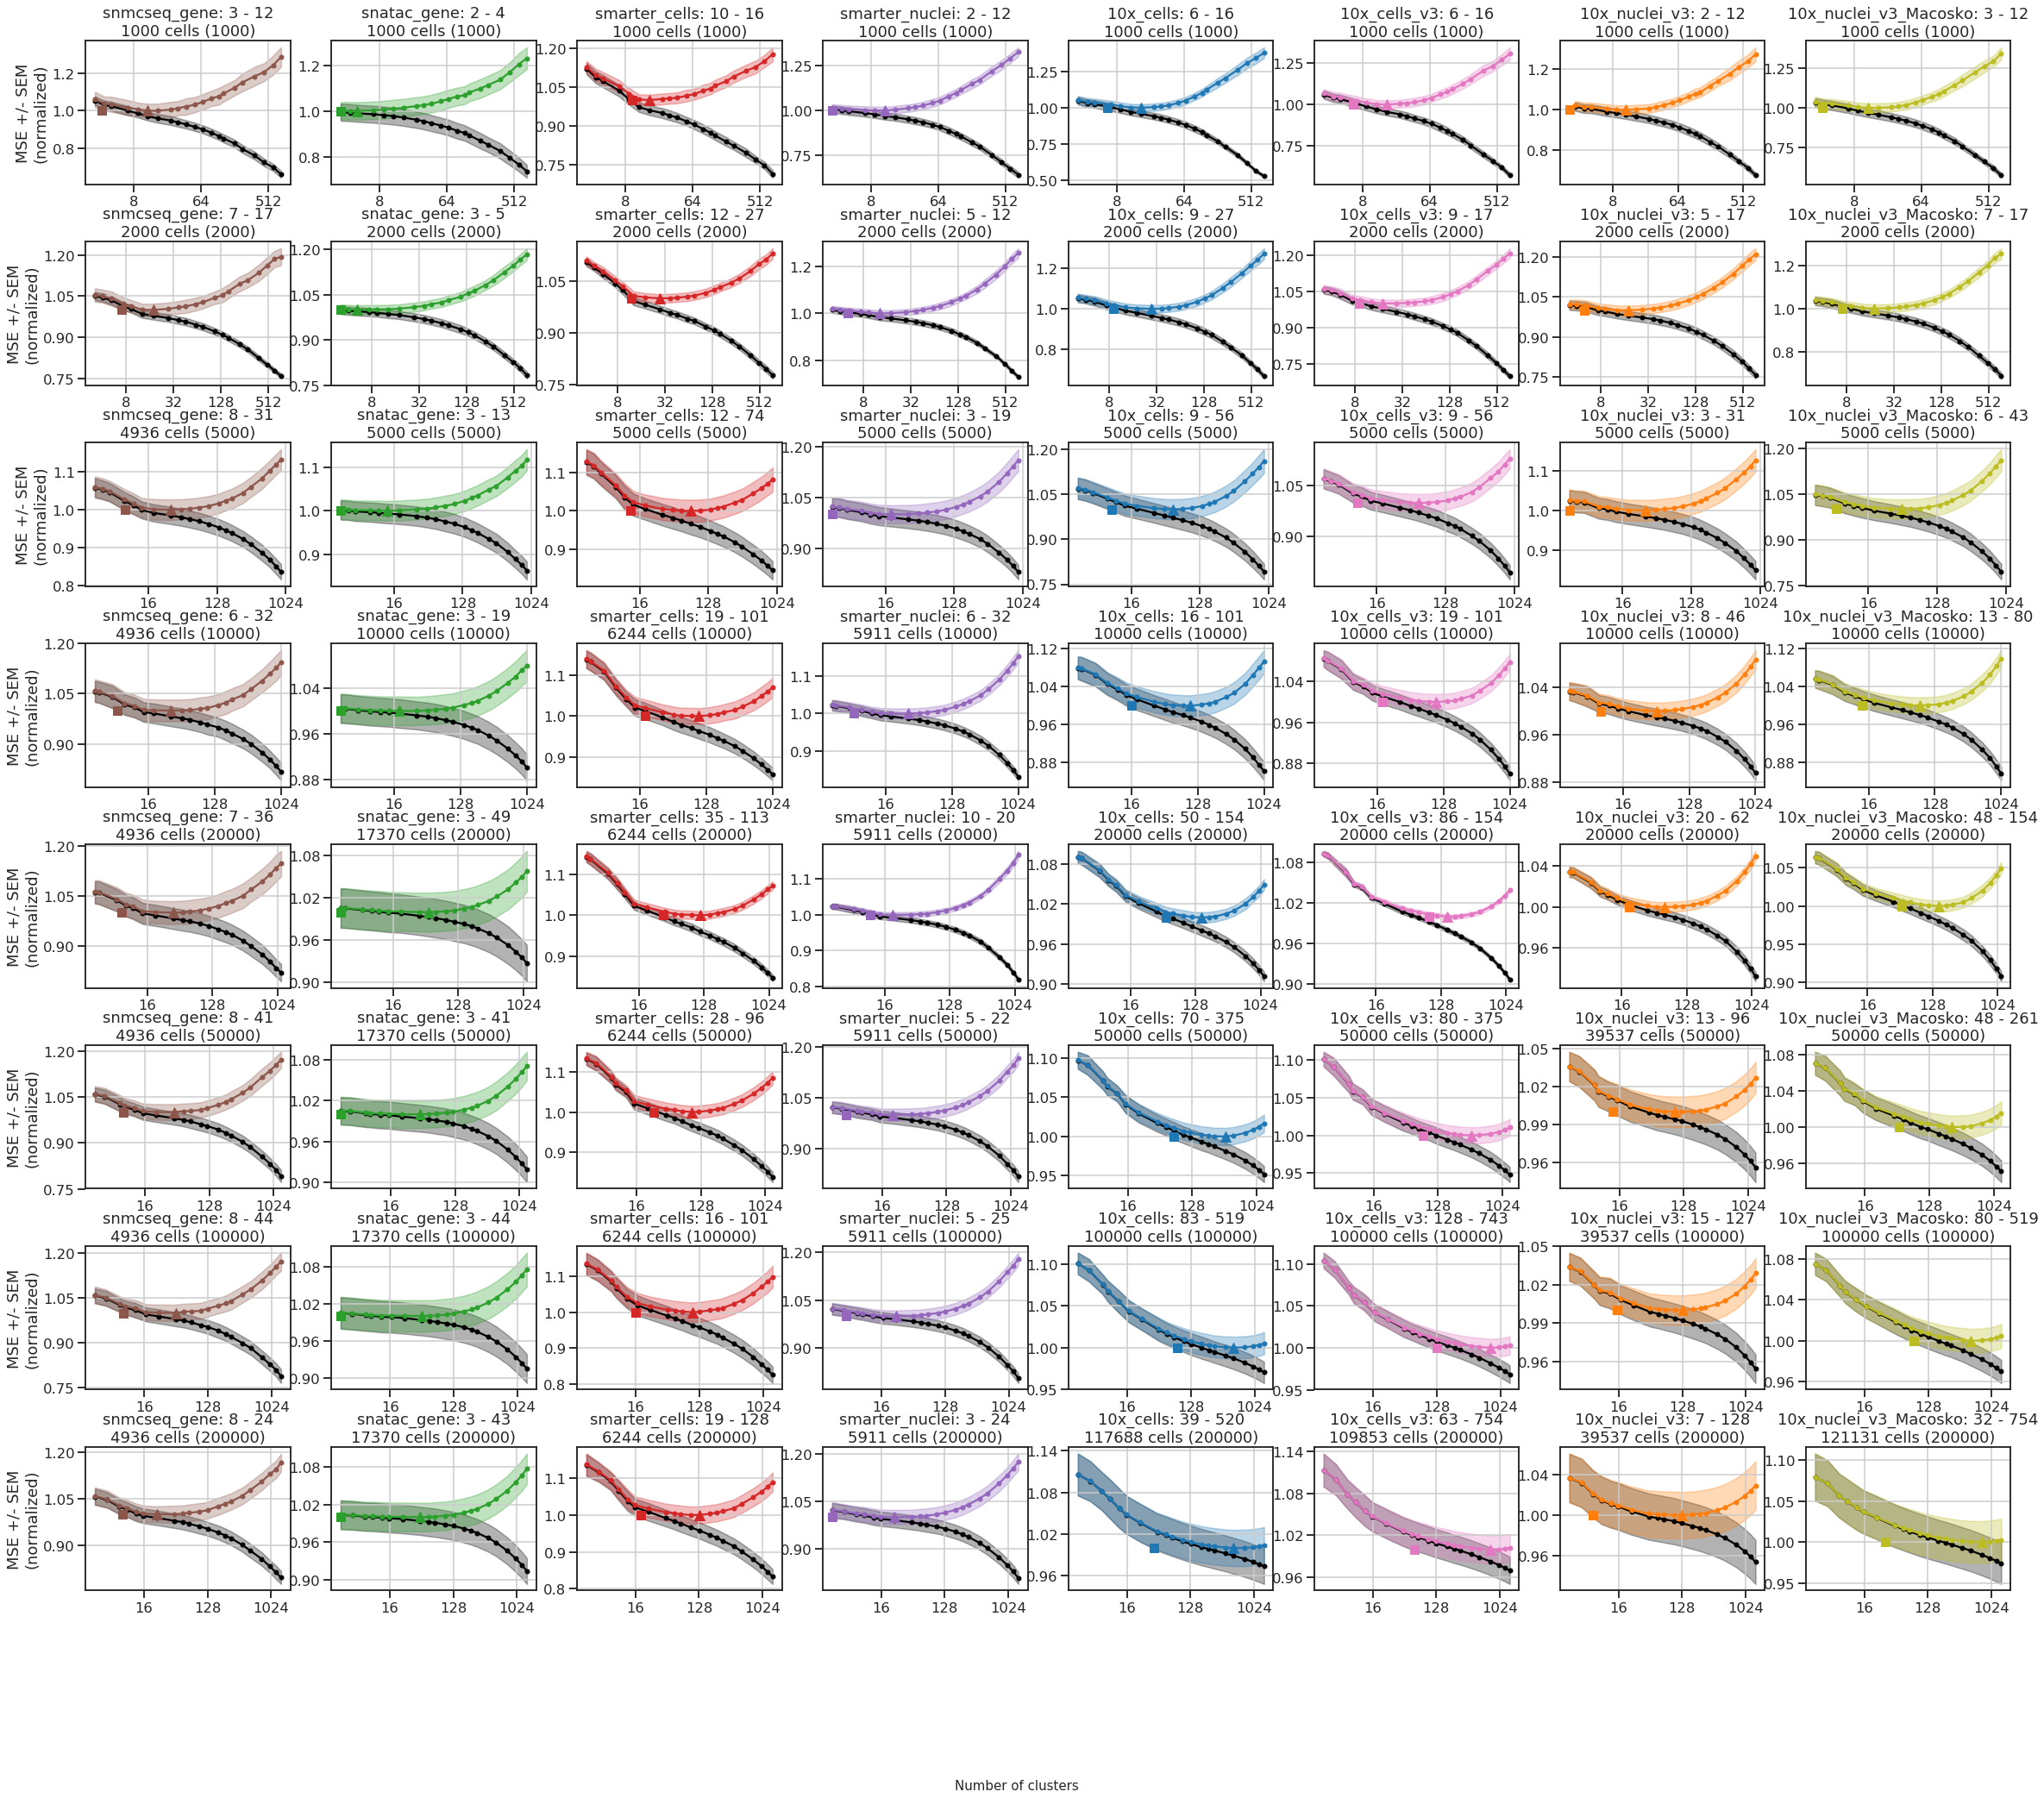

In [26]:

output = os.path.join(output_figure_dir, analysis_name+'_0.pdf')

res_sum_sum = []
scale = 1
    
    
num_ns = len(ns)
nx = len(mods_selected)
ny = num_ns 
    
fig, axs = plt.subplots(ny, nx, figsize=(5*nx*scale,4*ny*scale))
axs = axs.flatten()
ax_idx = -1 

for i, n in enumerate(ns):
    name = name_format.format(n)
    outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
    output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
    output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
    output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
    output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
    output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
    
    if not os.path.isfile(output_results):
        continue

    # Getting back the objects:
    with open(output_results, 'rb') as f: 
        (
         res_nclsts, res,
        ) = pickle.load(f)

    res_nclsts_summary = res_nclsts.groupby('resolution').agg({'nclsts': ['mean', 'std']})
    res_summary = res.groupby(['resolution', 'mod']).agg({'mse': ['mean', 'std'],
                                                          'mse_t': ['mean', 'std'],
                                                        })

#     output = output_figures.format('cluster_cv_nosharey', 'pdf')
    for j, mod in enumerate(mods_selected):
        metadata = pd.read_csv(meta_f.format(mod), sep="\t") #.reset_index().set_index(settings[mod].cell_col)
        n_cell = min([len(metadata), n])
        logging.info(n)
        logging.info(mod)
        
        ax_idx += 1
        ax = axs[ax_idx]
        
        n_folds = 5
        x = res_nclsts_summary['nclsts']['mean'].values
        ys = res_summary.xs(mod, level='mod')
        base_level = np.min(ys['mse']['mean'].values)
        y, y_err = ys['mse']['mean'].values/base_level, (ys['mse']['std'].values/np.sqrt(n_folds))/base_level, 
        yt, yt_err = ys['mse_t']['mean'].values/base_level, (ys['mse_t']['std'].values/np.sqrt(n_folds))/base_level, 

        if j == 0:
            ylabel = 'MSE +/- SEM\n(normalized)'
        else: 
            ylabel = ''
        xlabel = ''
        min_x_se, min_x, min_y = plot_bi_cv_subfig(ax, x, 
                                                  y, y_err,
                                                  yt, yt_err,
                                                  settings[mod].color, mod, 
                                                  xlabel=xlabel,
                                                  ylabel=ylabel
                                                 )
        ax.yaxis.set_major_locator(mtick.MaxNLocator(4))
        ax.set_title(ax.get_title()+'\n{} cells ({})'.format(n_cell, n))
        # end for

        res_sum_sum.append({'mod': mod,
                            'n': n,
                            'n_cell': n_cell,
                            'n_clst_min': min_x,  
                            'n_clst_1se': min_x_se, 
                           })
        
res_sum_sum = pd.DataFrame(res_sum_sum)

fig.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.1)
fig.text(0.5, 0, 'Number of clusters', ha='center', fontsize=15)
fig.savefig(output, bbox_inches='tight')
plt.show()

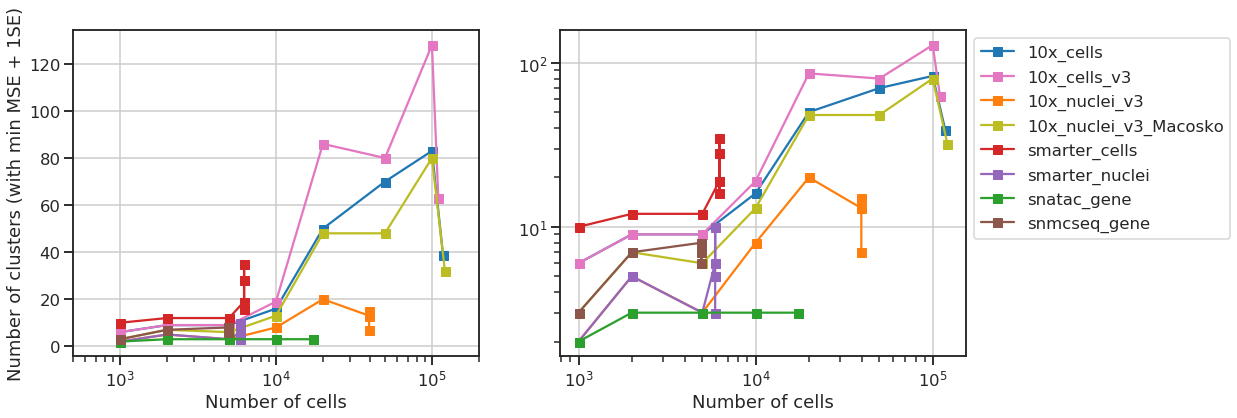

In [27]:
output = os.path.join(output_figure_dir, analysis_name+'_1.pdf')
fig, axs = plt.subplots(1,2, figsize=(8*2, 6))
for i, ax in enumerate(axs):
    for mod, df_sub in res_sum_sum.groupby('mod'):
        df_sub = df_sub.sort_values('n_cell')
        x = df_sub['n_cell'].values
        y = df_sub['n_clst_1se'].values
        c = settings[mod].color 
        ax.plot(x, y, '-s', color=c, label=mod)

    ax.set_xscale('log', basex=10)
    ax.set_xlabel('Number of cells')
    if i == 0:
        ax.set_ylabel('Number of clusters (with min MSE + 1SE)')
        ax.set_xlim([1e3-5e2, 2e5])
    else:
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_yscale('log', basey=10)
#         ax.set_ylim([0,60])
#     ax.set_ylim([0.8, ax.get_ylim()[1]])
fig.savefig(output, bbox_inches='tight')
plt.show()

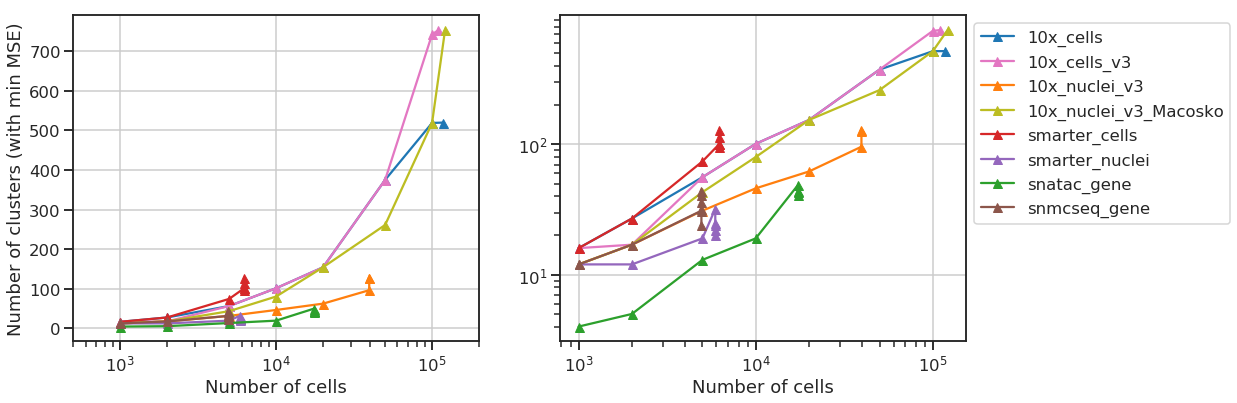

In [28]:
output = os.path.join(output_figure_dir, analysis_name+'_2.pdf')
fig, axs = plt.subplots(1,2, figsize=(8*2, 6))
for i, ax in enumerate(axs):
    for mod, df_sub in res_sum_sum.groupby('mod'):
        df_sub = df_sub.sort_values('n_cell')
        x = df_sub['n_cell'].values
        y = df_sub['n_clst_min'].values
        c = settings[mod].color 
        ax.plot(x, y, '-^', color=c, label=mod, alpha=1, zorder=2)

    ax.set_xscale('log', basex=10)
    ax.set_xlabel('Number of cells')
    if i == 0:
        ax.set_ylabel('Number of clusters (with min MSE)')
        ax.set_xlim([1e3-5e2, 2e5])
    else:
        ax.legend(bbox_to_anchor=(1,1))
        ax.set_yscale('log')
fig.savefig(output, bbox_inches='tight')
plt.show()

07/29/2019 10:48:55 AM 1000
07/29/2019 10:48:55 AM snmcseq_gene
07/29/2019 10:48:55 AM 2000
07/29/2019 10:48:55 AM snmcseq_gene
07/29/2019 10:48:56 AM 5000
07/29/2019 10:48:56 AM snmcseq_gene
07/29/2019 10:48:56 AM 10000
07/29/2019 10:48:56 AM snmcseq_gene
07/29/2019 10:48:56 AM 20000
07/29/2019 10:48:56 AM snmcseq_gene
07/29/2019 10:48:56 AM 50000
07/29/2019 10:48:56 AM snmcseq_gene
07/29/2019 10:48:56 AM 100000
07/29/2019 10:48:56 AM snmcseq_gene
07/29/2019 10:48:56 AM 200000
07/29/2019 10:48:56 AM snmcseq_gene
07/29/2019 10:48:56 AM 1000
07/29/2019 10:48:56 AM snatac_gene
07/29/2019 10:48:56 AM 2000
07/29/2019 10:48:56 AM snatac_gene
07/29/2019 10:48:57 AM 5000
07/29/2019 10:48:57 AM snatac_gene
07/29/2019 10:48:57 AM 10000
07/29/2019 10:48:57 AM snatac_gene
07/29/2019 10:48:57 AM 20000
07/29/2019 10:48:57 AM snatac_gene
07/29/2019 10:48:57 AM 50000
07/29/2019 10:48:57 AM snatac_gene
07/29/2019 10:48:57 AM 100000
07/29/2019 10:48:57 AM snatac_gene
07/29/2019 10:48:57 AM 200000
07/29

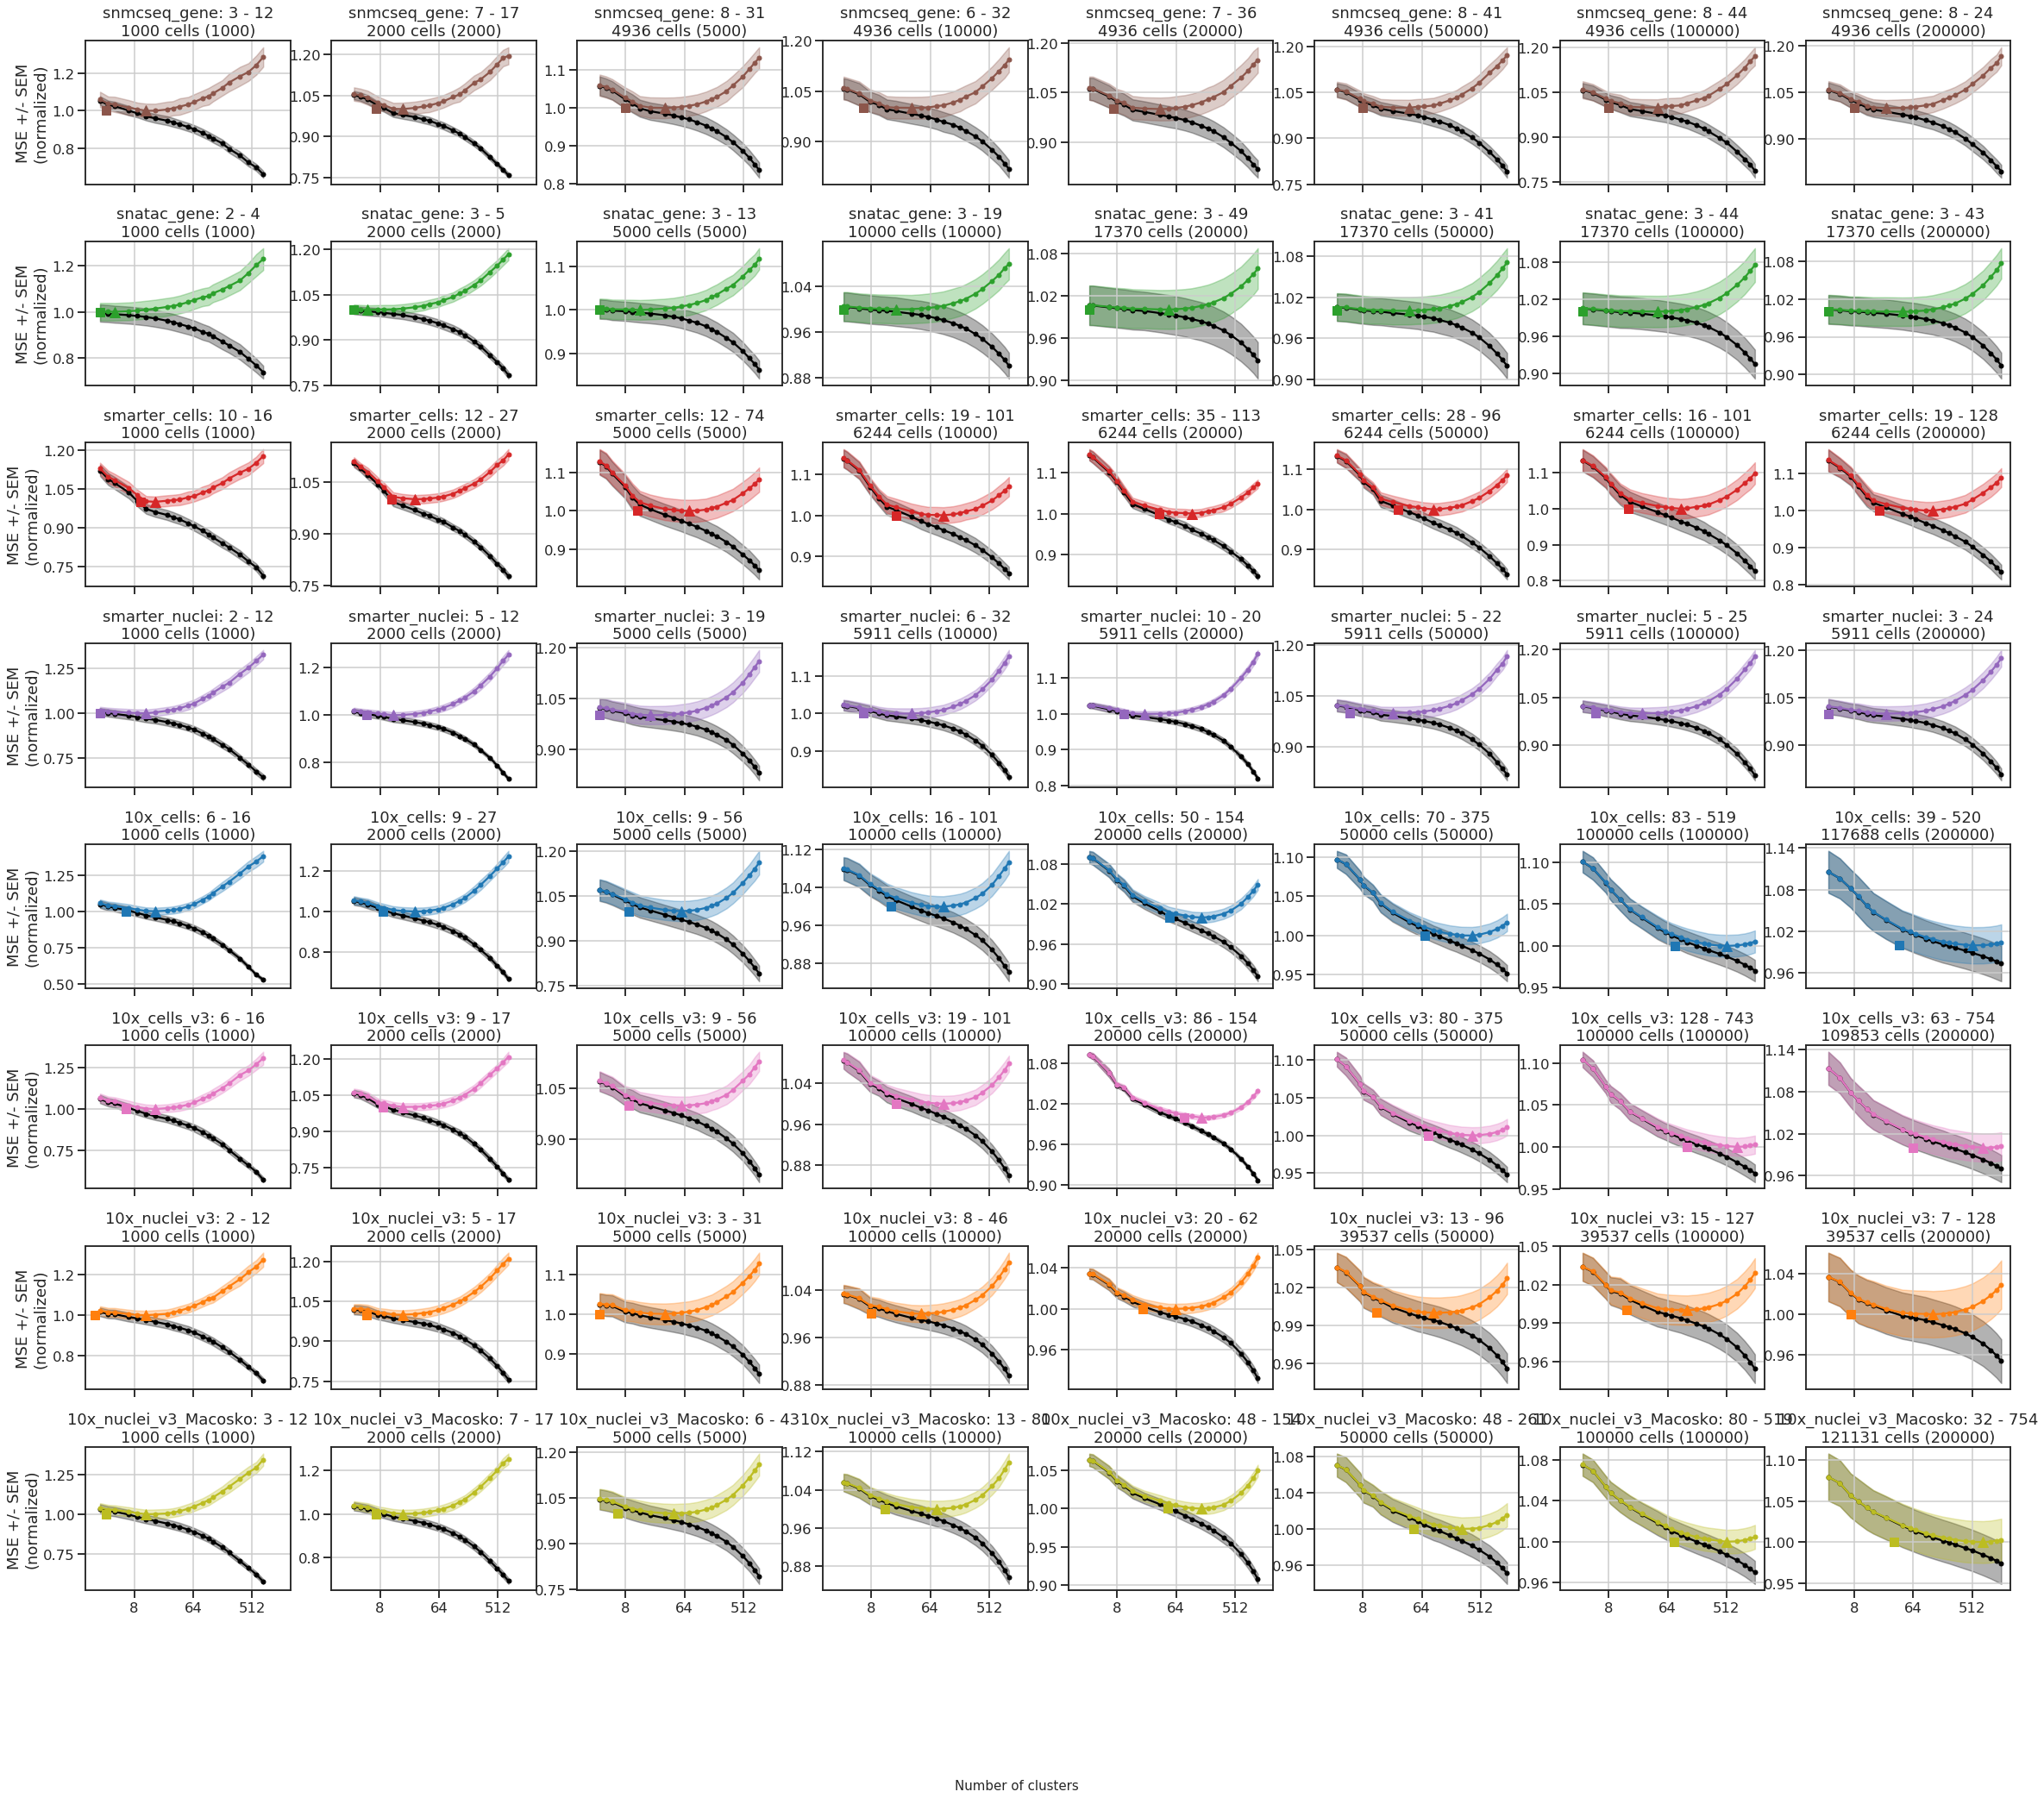

In [36]:
output = os.path.join(output_figure_dir, analysis_name+'_3.pdf')

res_sum_sum = []
scale = 1
    
num_ns = len(ns)
nx = num_ns
ny = len(mods_selected) 
    
fig, axs = plt.subplots(ny, nx, figsize=(5*nx*scale,4*ny*scale), sharex=True)
axs = axs.flatten()
ax_idx = -1 

for j, mod in enumerate(mods_selected):
    for i, n in enumerate(ns):
        name = name_format.format(n)
        outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
        output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
        output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
        output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
        output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
        output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)

        if not os.path.isfile(output_results):
            continue

        # Getting back the objects:
        with open(output_results, 'rb') as f: 
            (
             res_nclsts, res,
            ) = pickle.load(f)

        res_nclsts_summary = res_nclsts.groupby('resolution').agg({'nclsts': ['mean', 'std']})
        res_summary = res.groupby(['resolution', 'mod']).agg({'mse': ['mean', 'std'],
                                                              'mse_t': ['mean', 'std'],
                                                            })

        metadata = pd.read_csv(meta_f.format(mod), sep="\t") #.reset_index().set_index(settings[mod].cell_col)
        n_cell = min([len(metadata), n])
        logging.info(n)
        logging.info(mod)

        ax_idx += 1
        ax = axs[ax_idx]

        n_folds = 5
        x = res_nclsts_summary['nclsts']['mean'].values
        ys = res_summary.xs(mod, level='mod')
        base_level = np.min(ys['mse']['mean'].values)
        y, y_err = ys['mse']['mean'].values/base_level, (ys['mse']['std'].values/np.sqrt(n_folds))/base_level, 
        yt, yt_err = ys['mse_t']['mean'].values/base_level, (ys['mse_t']['std'].values/np.sqrt(n_folds))/base_level, 

        if i == 0:
            ylabel = 'MSE +/- SEM\n(normalized)'
        else: 
            ylabel = ''
        xlabel = ''
        min_x_se, min_x, min_y = plot_bi_cv_subfig(ax, x, 
                                                  y, y_err,
                                                  yt, yt_err,
                                                  settings[mod].color, mod, 
                                                  xlabel=xlabel,
                                                  ylabel=ylabel
                                                 )
        ax.yaxis.set_major_locator(mtick.MaxNLocator(4))
        ax.set_title(ax.get_title()+'\n{} cells ({})'.format(n_cell, n))
        # end for

        res_sum_sum.append({'mod': mod,
                            'n': n,
                            'n_cell': n_cell,
                            'n_clst_min': min_x,  
                            'n_clst_1se': min_x_se, 
                           })
        
res_sum_sum = pd.DataFrame(res_sum_sum)

fig.subplots_adjust(hspace=0.4, wspace=0.2, bottom=0.1)
fig.text(0.5, 0, 'Number of clusters', ha='center', fontsize=15)
fig.savefig(output, bbox_inches='tight')
plt.show()